# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from collections import defaultdict
from scipy.stats import beta
from scipy.special import betaln
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-besra'
epochs = 10
batch_size = 64
sequence_length = 80

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/undersampled.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (3328, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,USER USER USER USER BANCI KALENG MALU GA BISA ...,1,1,1,0,0,0,0,1,0,1,0,0
1,USER Bu guru enakan jadi jablay atau guru esde...,1,1,1,0,0,0,0,1,0,1,0,0
2,Jadi cowo itu harus Gantle kalo ga Gantle itu ...,1,1,0,1,0,0,0,1,0,0,1,0
3,USER Awaasss... Jgn sampe beritanya sampe ke a...,1,1,1,0,0,0,1,0,0,1,0,0
4,USER udah biasa kali. Gue kpoper tapi kalo ngo...,1,1,1,0,0,0,0,1,0,1,0,0


In [7]:
data.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,USER USER USER USER BANCI KALENG MALU GA BISA ...,1,1,1,0,0,0,0,1,0,1,0,0
1,USER Bu guru enakan jadi jablay atau guru esde...,1,1,1,0,0,0,0,1,0,1,0,0
2,Jadi cowo itu harus Gantle kalo ga Gantle itu ...,1,1,0,1,0,0,0,1,0,0,1,0
3,USER Awaasss... Jgn sampe beritanya sampe ke a...,1,1,1,0,0,0,1,0,0,1,0,0
4,USER udah biasa kali. Gue kpoper tapi kalo ngo...,1,1,1,0,0,0,0,1,0,1,0,0


In [8]:
data.HS.value_counts()

HS
0    1882
1    1446
Name: count, dtype: int64

In [9]:
data.Abusive.value_counts()

Abusive
0    1882
1    1446
Name: count, dtype: int64

In [10]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (1888, 13)
Non-toxic shape:  (1440, 13)


In [11]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [12]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [13]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [14]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2662,) (2662, 12)
(666,) (666, 12)


# BUILD DATASET & DATALOADERS

In [15]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts


# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [16]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=64, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [17]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 100

In [18]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [19]:
def train_model(current_train_size, train_indices, metrics, trials, i):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )
        
    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials+1}-model-{i+1}-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"Model {i+1} - Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
        
    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Training completed in {duration} s")
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(best_result['accuracy'])
        metrics[1].append(best_result['f1_micro'])
        metrics[2].append(best_result['f1_macro'])

# PLOT RESULT

In [20]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [21]:
def beta_score(p, y, alpha=0.1, beta=3):
    """Calculates Beta score for a given probability p and label y."""
    
    if y == 1:
        return -betaln(alpha, beta + 1) + betaln(alpha + p, beta + 1 - p)
    elif y == 0:
        return -betaln(alpha + 1, beta) + betaln(alpha + 1 - p, beta + p)
    else:
        raise ValueError("Invalid label: y must be 0 or 1.")

def bayesian_update(prior, likelihood, evidence, alpha=0.1, beta_param=3):
    """ 
    Bayes' Theorem: P(y'|x') = P(x'|y') * P(y') / P(x')
    P(y'|x') or likelihood = model probs
    p(y') or prior = class probabilities
    p(x') or evidence = 1 / number of data
    """
    
    # Using the Beta score to simulate the posterior
    posterior = (likelihood * prior) / evidence
    
    # We calculate the posterior using the Beta distribution
    return posterior

def compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx):
    scores_before = []
    scores_after = []

    # Before data addition: calculate Beta score for predicted prob
    scores_before.append(beta_score(predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    scores_before.append(beta_score(1-predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    
    # After data addition: use Bayesian update (posterior probability)
    for k in range(2):
        prior = predicted_prob
        likelihood = class_probs[class_idx][k]  # Likelihood is the true label (0 or 1)
        posterior = bayesian_update(prior, likelihood, 1)
        scores_after.append(beta_score(posterior, int(1 if posterior >= 0.5 else 0)))

    score_diff_0 = scores_after[0] - scores_before[0]
    score_diff_1 = scores_after[1] - scores_before[1]
    return label_probs['0'] * score_diff_0 + label_probs['1'] * score_diff_1

# Function to compute Expected Score Change (∆Q)
def besra_sampling(models, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    current_train_size = len(train_indices)
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    labeled_dataset = HateSpeechDataset(current_X_train, current_y_train, tokenizer, max_length=sequence_length)
    label_probs = labeled_dataset.get_global_probs()
    class_probs = labeled_dataset.get_per_class_probs()

    for model in models:
        model.to(device)
        model.eval()
    start_time = time.time()
    score_changes = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        model_probs = []

        for model in models:
            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probs = torch.sigmoid(logits)  # Multi-label classification uses sigmoid
                model_probs.append(probs.unsqueeze(0))  # Add batch dimension for averaging
        
        # Stack all model predictions and compute the mean across models
        model_probs = torch.cat(model_probs, dim=0)  # Concatenate predictions across models
        probs = model_probs.mean(dim=0)  # Take the mean along the model axis

        # Calculate Beta scores before and after data addition
        for i in range(len(probs)):
            score_diff = []
            for class_idx in range(probs.shape[1]):
                predicted_prob = probs[i, class_idx].item()
                score_diff.append(compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx))
            
            score_changes.append(np.mean(score_diff))
    
    accelerator.wait_for_everyone()    
    if accelerator.is_local_main_process:
        score_changes = np.array(score_changes)
        score_changes = score_changes.reshape(-1, 1)

        target_samples = math.ceil(0.1 * len(X_pool))
        collected_indices = set()
        thresholds = []
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break

        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)

        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(score_changes)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(score_changes[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'HS': [y_train[i][0] for i in temp],
                    'Abusive': [y_train[i][1] for i in temp],
                    'HS_Individual': [y_train[i][2] for i in temp],
                    'HS_Group': [y_train[i][3] for i in temp],
                    'HS_Religion': [y_train[i][4] for i in temp],
                    'HS_Race': [y_train[i][5] for i in temp],
                    'HS_Physical': [y_train[i][6] for i in temp],
                    'HS_Gender': [y_train[i][7] for i in temp],
                    'HS_Other': [y_train[i][8] for i in temp],
                    'HS_Weak': [y_train[i][9] for i in temp],
                    'HS_Moderate': [y_train[i][10] for i in temp],
                    'HS_Strong': [y_train[i][11] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [22]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size

    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model_accuracies = manager.list()
        model_f1_micros = manager.list()
        model_f1_macros = manager.list()
        
        # Train the model
        for j in range(3):
            set_seed(seed[j])
            args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
            notebook_launcher(train_model, args, num_processes=2)

        data_used.append(current_train_size)
        accuracies.append(np.mean(model_accuracies))
        f1_micros.append(np.mean(model_f1_micros))
        f1_macros.append(np.mean(model_f1_macros))
        print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(model_accuracies), 4)}, F1 Micro: {round(np.mean(model_f1_micros), 4)}, F1 Macro: {round(np.mean(model_f1_macros), 4)}")

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        models = []
        for j in range(3):
            model = BertForSequenceClassification.from_pretrained(f'{filename}-{i+1}-model-{j+1}-{percentage}')
            models.append(model)
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (models, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(besra_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model_accuracies = manager.list()
    model_f1_micros = manager.list()
    model_f1_macros = manager.list()
    
    for j in range(3):
        set_seed(seed[j])
        args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
        notebook_launcher(train_model, args, num_processes=2)
        
    data_used.append(current_train_size)
    accuracies.append(np.mean(model_accuracies))
    f1_micros.append(np.mean(model_f1_micros))
    f1_macros.append(np.mean(model_f1_macros))
    print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(model_accuracies), 4)}, F1 Micro: {round(np.mean(model_f1_micros), 4)}, F1 Macro: {round(np.mean(model_f1_macros), 4)}")
        
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

# RUN THE LOOP

TRIAL 1
Random seed: [50, 67, 42]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6807, Accuracy: 0.7103, F1 Micro: 0.2587, F1 Macro: 0.1588
Epoch 2/10, Train Loss: 0.6025, Accuracy: 0.7939, F1 Micro: 0.2097, F1 Macro: 0.0907
Epoch 3/10, Train Loss: 0.5498, Accuracy: 0.8095, F1 Micro: 0.187, F1 Macro: 0.0701
Epoch 4/10, Train Loss: 0.4895, Accuracy: 0.8148, F1 Micro: 0.1836, F1 Macro: 0.0639
Epoch 5/10, Train Loss: 0.4502, Accuracy: 0.8197, F1 Micro: 0.2086, F1 Macro: 0.0669
Epoch 6/10, Train Loss: 0.4379, Accuracy: 0.8222, F1 Micro: 0.2338, F1 Macro: 0.0644
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4299, Accuracy: 0.8225, F1 Micro: 0.2611, F1 Macro: 0.0641
Epoch 8/10, Train Loss: 0.4177, Accuracy: 0.8232, F1 Micro: 0.2606, F1 Macro: 0.0639
Epoch 9/10, Train Loss: 0.3804, Accuracy: 0.823, F1 Micro: 0.248, F1 Macro: 0.0628
Epoch 10/10, Train Loss: 0.3757, Accuracy: 0.8228, F1 Micro: 0.2422, F1 Macro: 0.0621
Model 1 - Iteration 166: Accuracy: 0.8225, F1 Micro: 0.2611, F1 Macro: 0.0641
        

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.693, Accuracy: 0.6237, F1 Micro: 0.1759, F1 Macro: 0.1219
Epoch 2/10, Train Loss: 0.6204, Accuracy: 0.789, F1 Micro: 0.1329, F1 Macro: 0.0552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5658, Accuracy: 0.8123, F1 Micro: 0.2235, F1 Macro: 0.0711
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5018, Accuracy: 0.8238, F1 Micro: 0.3211, F1 Macro: 0.0986
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4557, Accuracy: 0.8303, F1 Micro: 0.3678, F1 Macro: 0.1101
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4464, Accuracy: 0.8313, F1 Micro: 0.3763, F1 Macro: 0.1107
Epoch 7/10, Train Loss: 0.4332, Accuracy: 0.8293, F1 Micro: 0.354, F1 Macro: 0.1017
Epoch 8/10, Train Loss: 0.4191, Accuracy: 0.8251, F1 Micro: 0.3052, F1 Macro: 0.0823
Epoch 9/10, Train Loss: 0.3815, Accuracy: 0.8223, F1 Micro: 0.2561, F1 Macro: 0.0675
Epoch 10/10, Train Loss: 0.3742, Accuracy: 0.8217, F1 Micro: 0.2383, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7205, Accuracy: 0.6487, F1 Micro: 0.358, F1 Macro: 0.1855
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6257, Accuracy: 0.7778, F1 Micro: 0.4057, F1 Macro: 0.1348
Epoch 3/10, Train Loss: 0.5641, Accuracy: 0.8005, F1 Micro: 0.4008, F1 Macro: 0.1074
Epoch 4/10, Train Loss: 0.5054, Accuracy: 0.8012, F1 Micro: 0.3382, F1 Macro: 0.0861
Epoch 5/10, Train Loss: 0.4625, Accuracy: 0.8072, F1 Micro: 0.2962, F1 Macro: 0.0637
Epoch 6/10, Train Loss: 0.4448, Accuracy: 0.8173, F1 Micro: 0.2741, F1 Macro: 0.0614
Epoch 7/10, Train Loss: 0.4338, Accuracy: 0.8192, F1 Micro: 0.2543, F1 Macro: 0.0608
Epoch 8/10, Train Loss: 0.4152, Accuracy: 0.8205, F1 Micro: 0.2556, F1 Macro: 0.0617
Epoch 9/10, Train Loss: 0.3786, Accuracy: 0.8202, F1 Micro: 0.2361, F1 Macro: 0.0598
Epoch 10/10, Train Loss: 0.372, Accuracy: 0.8199, F1 Micro: 0.2148, F1 Macro: 0.0574
Model 3 - Iteration 166: Accuracy: 0.7778, F1 Micro: 0.4057, F1 Macro: 0.1348
       

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6397, Accuracy: 0.7937, F1 Micro: 0.1659, F1 Macro: 0.0712
Epoch 2/10, Train Loss: 0.522, Accuracy: 0.8065, F1 Micro: 0.0699, F1 Macro: 0.0262
Epoch 3/10, Train Loss: 0.4527, Accuracy: 0.8083, F1 Micro: 0.0606, F1 Macro: 0.0225
Epoch 4/10, Train Loss: 0.4308, Accuracy: 0.8168, F1 Micro: 0.1619, F1 Macro: 0.0486
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3994, Accuracy: 0.8203, F1 Micro: 0.2, F1 Macro: 0.0561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3978, Accuracy: 0.8216, F1 Micro: 0.2111, F1 Macro: 0.0597
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3604, Accuracy: 0.8292, F1 Micro: 0.2871, F1 Macro: 0.0867
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3661, Accuracy: 0.8337, F1 Micro: 0.349, F1 Macro: 0.1059
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3582, Accuracy: 0.8377, F1 Micro: 0.3798, F1 Macro: 0.1226
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6543, Accuracy: 0.787, F1 Micro: 0.1454, F1 Macro: 0.0592
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5373, Accuracy: 0.8178, F1 Micro: 0.2568, F1 Macro: 0.0782
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4612, Accuracy: 0.8306, F1 Micro: 0.3579, F1 Macro: 0.1086
Epoch 4/10, Train Loss: 0.4333, Accuracy: 0.8244, F1 Micro: 0.2796, F1 Macro: 0.0848
Epoch 5/10, Train Loss: 0.4014, Accuracy: 0.8231, F1 Micro: 0.2404, F1 Macro: 0.0685
Epoch 6/10, Train Loss: 0.3935, Accuracy: 0.827, F1 Micro: 0.2701, F1 Macro: 0.083
Epoch 7/10, Train Loss: 0.3557, Accuracy: 0.8336, F1 Micro: 0.3399, F1 Macro: 0.1053
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3606, Accuracy: 0.8381, F1 Micro: 0.3955, F1 Macro: 0.121
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3515, Accuracy: 0.8432, F1 Micro: 0.4232, F1 Macro: 0.1389
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.3203, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6781, Accuracy: 0.7762, F1 Micro: 0.4138, F1 Macro: 0.145
Epoch 2/10, Train Loss: 0.5483, Accuracy: 0.8028, F1 Micro: 0.3649, F1 Macro: 0.0978
Epoch 3/10, Train Loss: 0.4625, Accuracy: 0.8183, F1 Micro: 0.2465, F1 Macro: 0.0595
Epoch 4/10, Train Loss: 0.4354, Accuracy: 0.8143, F1 Micro: 0.1432, F1 Macro: 0.044
Epoch 5/10, Train Loss: 0.3994, Accuracy: 0.8172, F1 Micro: 0.1784, F1 Macro: 0.0512
Epoch 6/10, Train Loss: 0.3975, Accuracy: 0.8162, F1 Micro: 0.1622, F1 Macro: 0.0485
Epoch 7/10, Train Loss: 0.361, Accuracy: 0.8243, F1 Micro: 0.236, F1 Macro: 0.0709
Epoch 8/10, Train Loss: 0.3622, Accuracy: 0.8338, F1 Micro: 0.3339, F1 Macro: 0.1023
Epoch 9/10, Train Loss: 0.3595, Accuracy: 0.8334, F1 Micro: 0.3253, F1 Macro: 0.1027
Epoch 10/10, Train Loss: 0.3265, Accuracy: 0.8423, F1 Micro: 0.3928, F1 Macro: 0.1323
Model 3 - Iteration 416: Accuracy: 0.7762, F1 Micro: 0.4138, F1 Macro: 0.145
               precision    recall  f1-scor

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6103, Accuracy: 0.8082, F1 Micro: 0.1868, F1 Macro: 0.0605
Epoch 2/10, Train Loss: 0.4745, Accuracy: 0.8165, F1 Micro: 0.1755, F1 Macro: 0.062
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4364, Accuracy: 0.8204, F1 Micro: 0.1985, F1 Macro: 0.0582
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4033, Accuracy: 0.8287, F1 Micro: 0.2813, F1 Macro: 0.085
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3858, Accuracy: 0.8349, F1 Micro: 0.3658, F1 Macro: 0.1107
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3771, Accuracy: 0.8427, F1 Micro: 0.4332, F1 Macro: 0.1628
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3436, Accuracy: 0.8516, F1 Micro: 0.4755, F1 Macro: 0.2175
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3227, Accuracy: 0.8575, F1 Micro: 0.5339, F1 Macro: 0.2634
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2826, Accuracy: 0.8584, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6251, Accuracy: 0.8091, F1 Micro: 0.2309, F1 Macro: 0.0647
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4832, Accuracy: 0.8316, F1 Micro: 0.4012, F1 Macro: 0.116
Epoch 3/10, Train Loss: 0.4396, Accuracy: 0.8256, F1 Micro: 0.2829, F1 Macro: 0.086
Epoch 4/10, Train Loss: 0.4038, Accuracy: 0.8314, F1 Micro: 0.3325, F1 Macro: 0.1023
Epoch 5/10, Train Loss: 0.3844, Accuracy: 0.8381, F1 Micro: 0.3915, F1 Macro: 0.119
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3742, Accuracy: 0.8442, F1 Micro: 0.4421, F1 Macro: 0.1444
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3425, Accuracy: 0.8523, F1 Micro: 0.4779, F1 Macro: 0.2017
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3231, Accuracy: 0.8566, F1 Micro: 0.5332, F1 Macro: 0.2661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2803, Accuracy: 0.8608, F1 Micro: 0.5544, F1 Macro: 0.3212
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6401, Accuracy: 0.7971, F1 Micro: 0.4243, F1 Macro: 0.118
Epoch 2/10, Train Loss: 0.4869, Accuracy: 0.8181, F1 Micro: 0.2584, F1 Macro: 0.0637
Epoch 3/10, Train Loss: 0.4413, Accuracy: 0.8188, F1 Micro: 0.1956, F1 Macro: 0.0583
Epoch 4/10, Train Loss: 0.4042, Accuracy: 0.822, F1 Micro: 0.219, F1 Macro: 0.0667
Epoch 5/10, Train Loss: 0.3908, Accuracy: 0.8322, F1 Micro: 0.3255, F1 Macro: 0.1001
Epoch 6/10, Train Loss: 0.3857, Accuracy: 0.8371, F1 Micro: 0.3626, F1 Macro: 0.1164
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3526, Accuracy: 0.8462, F1 Micro: 0.4284, F1 Macro: 0.1598
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3331, Accuracy: 0.8538, F1 Micro: 0.4896, F1 Macro: 0.2287
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2996, Accuracy: 0.8608, F1 Micro: 0.5484, F1 Macro: 0.3155
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2954, Accuracy: 0.8594, F1 Micro: 0.5546, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6031, Accuracy: 0.8102, F1 Micro: 0.2605, F1 Macro: 0.0723
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4625, Accuracy: 0.8327, F1 Micro: 0.3365, F1 Macro: 0.1048
Epoch 3/10, Train Loss: 0.4225, Accuracy: 0.8299, F1 Micro: 0.3025, F1 Macro: 0.0909
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3962, Accuracy: 0.8368, F1 Micro: 0.397, F1 Macro: 0.1176
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3887, Accuracy: 0.8438, F1 Micro: 0.4453, F1 Macro: 0.1669
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3697, Accuracy: 0.8524, F1 Micro: 0.4899, F1 Macro: 0.2221
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3223, Accuracy: 0.8597, F1 Micro: 0.5589, F1 Macro: 0.2944
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.296, Accuracy: 0.8631, F1 Micro: 0.5832, F1 Macro: 0.3558
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2703, Accuracy: 0.8702, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6178, Accuracy: 0.8124, F1 Micro: 0.2917, F1 Macro: 0.0811
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4726, Accuracy: 0.8316, F1 Micro: 0.4336, F1 Macro: 0.1206
Epoch 3/10, Train Loss: 0.4248, Accuracy: 0.8292, F1 Micro: 0.3151, F1 Macro: 0.0969
Epoch 4/10, Train Loss: 0.3956, Accuracy: 0.8369, F1 Micro: 0.3952, F1 Macro: 0.1177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3887, Accuracy: 0.8442, F1 Micro: 0.4473, F1 Macro: 0.1473
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3709, Accuracy: 0.8557, F1 Micro: 0.5121, F1 Macro: 0.2174
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3226, Accuracy: 0.8587, F1 Micro: 0.5568, F1 Macro: 0.2948
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2984, Accuracy: 0.865, F1 Micro: 0.5945, F1 Macro: 0.3795
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2751, Accuracy: 0.8676, F1 Micro: 0.6139, F1 Macro: 0.4076
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6258, Accuracy: 0.7974, F1 Micro: 0.4415, F1 Macro: 0.1236
Epoch 2/10, Train Loss: 0.4756, Accuracy: 0.8189, F1 Micro: 0.2319, F1 Macro: 0.0639
Epoch 3/10, Train Loss: 0.4247, Accuracy: 0.827, F1 Micro: 0.2858, F1 Macro: 0.0893
Epoch 4/10, Train Loss: 0.3972, Accuracy: 0.834, F1 Micro: 0.3462, F1 Macro: 0.1067
Epoch 5/10, Train Loss: 0.3959, Accuracy: 0.8404, F1 Micro: 0.4109, F1 Macro: 0.1251
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3782, Accuracy: 0.851, F1 Micro: 0.4817, F1 Macro: 0.1919
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3345, Accuracy: 0.8602, F1 Micro: 0.5478, F1 Macro: 0.2766
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3096, Accuracy: 0.8636, F1 Micro: 0.5839, F1 Macro: 0.3521
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2828, Accuracy: 0.8672, F1 Micro: 0.6136, F1 Macro: 0.4218
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2776, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.578, Accuracy: 0.814, F1 Micro: 0.29, F1 Macro: 0.082
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4503, Accuracy: 0.8332, F1 Micro: 0.355, F1 Macro: 0.1056
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.417, Accuracy: 0.8385, F1 Micro: 0.3936, F1 Macro: 0.1183
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3907, Accuracy: 0.8457, F1 Micro: 0.4514, F1 Macro: 0.1837
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3487, Accuracy: 0.8551, F1 Micro: 0.4983, F1 Macro: 0.2305
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3316, Accuracy: 0.8599, F1 Micro: 0.5351, F1 Macro: 0.2841
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3085, Accuracy: 0.8646, F1 Micro: 0.567, F1 Macro: 0.3508
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2772, Accuracy: 0.8715, F1 Micro: 0.6113, F1 Macro: 0.4096
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.259, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5908, Accuracy: 0.8224, F1 Micro: 0.3711, F1 Macro: 0.1057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.458, Accuracy: 0.832, F1 Micro: 0.3813, F1 Macro: 0.1118
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4168, Accuracy: 0.8364, F1 Micro: 0.3978, F1 Macro: 0.118
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3913, Accuracy: 0.8461, F1 Micro: 0.455, F1 Macro: 0.1602
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3532, Accuracy: 0.8567, F1 Micro: 0.5257, F1 Macro: 0.2459
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3313, Accuracy: 0.8615, F1 Micro: 0.5884, F1 Macro: 0.338
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.314, Accuracy: 0.8688, F1 Micro: 0.6089, F1 Macro: 0.3852
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2816, Accuracy: 0.8723, F1 Micro: 0.614, F1 Macro: 0.4162
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2626

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6022, Accuracy: 0.8015, F1 Micro: 0.435, F1 Macro: 0.1142
Epoch 2/10, Train Loss: 0.4572, Accuracy: 0.8251, F1 Micro: 0.281, F1 Macro: 0.0848
Epoch 3/10, Train Loss: 0.4181, Accuracy: 0.8292, F1 Micro: 0.2865, F1 Macro: 0.0905
Epoch 4/10, Train Loss: 0.3982, Accuracy: 0.8432, F1 Micro: 0.4143, F1 Macro: 0.1355
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3611, Accuracy: 0.8522, F1 Micro: 0.4745, F1 Macro: 0.2123
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.338, Accuracy: 0.8628, F1 Micro: 0.573, F1 Macro: 0.3363
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3192, Accuracy: 0.8663, F1 Micro: 0.5866, F1 Macro: 0.3566
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2908, Accuracy: 0.8698, F1 Micro: 0.6159, F1 Macro: 0.4162
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2673, Accuracy: 0.8742, F1 Micro: 0.6267, F1 Macro: 0.4475
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5675, Accuracy: 0.8164, F1 Micro: 0.3497, F1 Macro: 0.0968
Epoch 2/10, Train Loss: 0.4467, Accuracy: 0.83, F1 Micro: 0.3166, F1 Macro: 0.0936
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4147, Accuracy: 0.8381, F1 Micro: 0.4314, F1 Macro: 0.1235
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3807, Accuracy: 0.8493, F1 Micro: 0.5232, F1 Macro: 0.2384
Epoch 5/10, Train Loss: 0.355, Accuracy: 0.8561, F1 Micro: 0.5175, F1 Macro: 0.2478
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3203, Accuracy: 0.8661, F1 Micro: 0.5831, F1 Macro: 0.3631
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2905, Accuracy: 0.8755, F1 Micro: 0.6421, F1 Macro: 0.4372
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2578, Accuracy: 0.8763, F1 Micro: 0.6426, F1 Macro: 0.4559
Epoch 9/10, Train Loss: 0.2323, Accuracy: 0.8778, F1 Micro: 0.6419, F1 Macro: 0.4607
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5814, Accuracy: 0.8231, F1 Micro: 0.3976, F1 Macro: 0.1113
Epoch 2/10, Train Loss: 0.4516, Accuracy: 0.8312, F1 Micro: 0.3384, F1 Macro: 0.1035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4153, Accuracy: 0.839, F1 Micro: 0.4069, F1 Macro: 0.1218
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3831, Accuracy: 0.851, F1 Micro: 0.5045, F1 Macro: 0.1973
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3559, Accuracy: 0.8583, F1 Micro: 0.5195, F1 Macro: 0.2475
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3238, Accuracy: 0.8674, F1 Micro: 0.5983, F1 Macro: 0.3776
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2907, Accuracy: 0.8722, F1 Micro: 0.6222, F1 Macro: 0.4098
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2619, Accuracy: 0.8745, F1 Micro: 0.6412, F1 Macro: 0.4438
Epoch 9/10, Train Loss: 0.2352, Accuracy: 0.8741, F1 Micro: 0.6172, F1 Macro: 0.4358
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5918, Accuracy: 0.8061, F1 Micro: 0.4357, F1 Macro: 0.1126
Epoch 2/10, Train Loss: 0.4501, Accuracy: 0.8314, F1 Micro: 0.3382, F1 Macro: 0.1034
Epoch 3/10, Train Loss: 0.4151, Accuracy: 0.8373, F1 Micro: 0.3808, F1 Macro: 0.1154
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3878, Accuracy: 0.8466, F1 Micro: 0.4624, F1 Macro: 0.1705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3654, Accuracy: 0.8548, F1 Micro: 0.4842, F1 Macro: 0.2307
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3336, Accuracy: 0.8682, F1 Micro: 0.602, F1 Macro: 0.3683
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3018, Accuracy: 0.8713, F1 Micro: 0.6096, F1 Macro: 0.3956
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2701, Accuracy: 0.8763, F1 Micro: 0.6462, F1 Macro: 0.475
Epoch 9/10, Train Loss: 0.245, Accuracy: 0.8754, F1 Micro: 0.627, F1 Macro: 0.4652
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5585, Accuracy: 0.8222, F1 Micro: 0.3351, F1 Macro: 0.0985
Epoch 2/10, Train Loss: 0.4425, Accuracy: 0.8318, F1 Micro: 0.3249, F1 Macro: 0.099
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3998, Accuracy: 0.8396, F1 Micro: 0.4253, F1 Macro: 0.1366
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.364, Accuracy: 0.8543, F1 Micro: 0.5009, F1 Macro: 0.229
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3289, Accuracy: 0.8649, F1 Micro: 0.5871, F1 Macro: 0.345
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3057, Accuracy: 0.8701, F1 Micro: 0.596, F1 Macro: 0.3976
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2734, Accuracy: 0.8759, F1 Micro: 0.6237, F1 Macro: 0.4374
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2422, Accuracy: 0.879, F1 Micro: 0.6616, F1 Macro: 0.5164
Epoch 9/10, Train Loss: 0.2205, Accuracy: 0.881, F1 Micro: 0.6556, F1 Macro: 0.5203
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5726, Accuracy: 0.8274, F1 Micro: 0.407, F1 Macro: 0.1147
Epoch 2/10, Train Loss: 0.4441, Accuracy: 0.8338, F1 Micro: 0.3606, F1 Macro: 0.1092
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4011, Accuracy: 0.8427, F1 Micro: 0.444, F1 Macro: 0.1412
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3688, Accuracy: 0.8559, F1 Micro: 0.5136, F1 Macro: 0.2259
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3317, Accuracy: 0.865, F1 Micro: 0.6038, F1 Macro: 0.3761
Epoch 6/10, Train Loss: 0.313, Accuracy: 0.8686, F1 Micro: 0.5779, F1 Macro: 0.3694
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2757, Accuracy: 0.8736, F1 Micro: 0.625, F1 Macro: 0.4424
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2479, Accuracy: 0.8748, F1 Micro: 0.6495, F1 Macro: 0.4904
Epoch 9/10, Train Loss: 0.227, Accuracy: 0.8753, F1 Micro: 0.6212, F1 Macro: 0.4754
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5837, Accuracy: 0.8145, F1 Micro: 0.4067, F1 Macro: 0.1081
Epoch 2/10, Train Loss: 0.4462, Accuracy: 0.8291, F1 Micro: 0.3083, F1 Macro: 0.0938
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4039, Accuracy: 0.8422, F1 Micro: 0.4334, F1 Macro: 0.1278
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3748, Accuracy: 0.8515, F1 Micro: 0.4867, F1 Macro: 0.2037
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3417, Accuracy: 0.864, F1 Micro: 0.5923, F1 Macro: 0.3567
Epoch 6/10, Train Loss: 0.3203, Accuracy: 0.8685, F1 Micro: 0.5821, F1 Macro: 0.3885
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2891, Accuracy: 0.8754, F1 Micro: 0.6251, F1 Macro: 0.4374
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2542, Accuracy: 0.8781, F1 Micro: 0.6575, F1 Macro: 0.4945
Epoch 9/10, Train Loss: 0.2355, Accuracy: 0.8781, F1 Micro: 0.6278, F1 Macro: 0.4734
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5506, Accuracy: 0.8256, F1 Micro: 0.4006, F1 Macro: 0.1132
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4306, Accuracy: 0.8391, F1 Micro: 0.4168, F1 Macro: 0.1217
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4019, Accuracy: 0.8461, F1 Micro: 0.4713, F1 Macro: 0.1905
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3664, Accuracy: 0.8587, F1 Micro: 0.5206, F1 Macro: 0.2487
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3292, Accuracy: 0.8661, F1 Micro: 0.5845, F1 Macro: 0.3389
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.287, Accuracy: 0.8741, F1 Micro: 0.6284, F1 Macro: 0.4374
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2607, Accuracy: 0.8761, F1 Micro: 0.6562, F1 Macro: 0.484
Epoch 8/10, Train Loss: 0.2356, Accuracy: 0.8787, F1 Micro: 0.6489, F1 Macro: 0.5133
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2258, Accuracy: 0.8829, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5645, Accuracy: 0.8275, F1 Micro: 0.4342, F1 Macro: 0.1191
Epoch 2/10, Train Loss: 0.433, Accuracy: 0.8366, F1 Micro: 0.4212, F1 Macro: 0.1213
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4031, Accuracy: 0.8442, F1 Micro: 0.4701, F1 Macro: 0.1582
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3701, Accuracy: 0.8561, F1 Micro: 0.5004, F1 Macro: 0.2275
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3313, Accuracy: 0.8639, F1 Micro: 0.5792, F1 Macro: 0.3435
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.291, Accuracy: 0.8711, F1 Micro: 0.6281, F1 Macro: 0.4211
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2632, Accuracy: 0.8745, F1 Micro: 0.6445, F1 Macro: 0.4651
Epoch 8/10, Train Loss: 0.2432, Accuracy: 0.878, F1 Micro: 0.636, F1 Macro: 0.4853
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.231, Accuracy: 0.8805, F1 Micro: 0.6868, F1 Macro: 0.5755
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5716, Accuracy: 0.8183, F1 Micro: 0.35, F1 Macro: 0.0947
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4327, Accuracy: 0.8384, F1 Micro: 0.4271, F1 Macro: 0.123
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4052, Accuracy: 0.8429, F1 Micro: 0.4688, F1 Macro: 0.1614
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3751, Accuracy: 0.8589, F1 Micro: 0.5124, F1 Macro: 0.2427
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3397, Accuracy: 0.8661, F1 Micro: 0.5724, F1 Macro: 0.3146
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2968, Accuracy: 0.871, F1 Micro: 0.6215, F1 Macro: 0.4321
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2696, Accuracy: 0.8741, F1 Micro: 0.6535, F1 Macro: 0.4823
Epoch 8/10, Train Loss: 0.2463, Accuracy: 0.8789, F1 Micro: 0.6462, F1 Macro: 0.503
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2351, Accuracy: 0.8847, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.543, Accuracy: 0.8306, F1 Micro: 0.3718, F1 Macro: 0.1103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.433, Accuracy: 0.8371, F1 Micro: 0.456, F1 Macro: 0.126
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3986, Accuracy: 0.8516, F1 Micro: 0.5142, F1 Macro: 0.2242
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3454, Accuracy: 0.8641, F1 Micro: 0.5787, F1 Macro: 0.3166
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3123, Accuracy: 0.8685, F1 Micro: 0.6203, F1 Macro: 0.4109
Epoch 6/10, Train Loss: 0.2741, Accuracy: 0.8712, F1 Micro: 0.6026, F1 Macro: 0.4041
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2504, Accuracy: 0.8765, F1 Micro: 0.6259, F1 Macro: 0.4485
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2256, Accuracy: 0.8821, F1 Micro: 0.6615, F1 Macro: 0.5381
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1958, Accuracy: 0.8835, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5561, Accuracy: 0.8258, F1 Micro: 0.4359, F1 Macro: 0.1187
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4363, Accuracy: 0.8364, F1 Micro: 0.446, F1 Macro: 0.1259
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3999, Accuracy: 0.8494, F1 Micro: 0.4874, F1 Macro: 0.1866
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3497, Accuracy: 0.8612, F1 Micro: 0.5639, F1 Macro: 0.2965
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3185, Accuracy: 0.8672, F1 Micro: 0.6189, F1 Macro: 0.3959
Epoch 6/10, Train Loss: 0.2764, Accuracy: 0.8704, F1 Micro: 0.5969, F1 Macro: 0.3873
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.253, Accuracy: 0.8761, F1 Micro: 0.6258, F1 Macro: 0.4415
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2325, Accuracy: 0.8781, F1 Micro: 0.6322, F1 Macro: 0.4857
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1983, Accuracy: 0.8811, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5625, Accuracy: 0.82, F1 Micro: 0.2889, F1 Macro: 0.0819
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4356, Accuracy: 0.8365, F1 Micro: 0.3775, F1 Macro: 0.1141
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4043, Accuracy: 0.8448, F1 Micro: 0.4211, F1 Macro: 0.1485
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3555, Accuracy: 0.8624, F1 Micro: 0.5678, F1 Macro: 0.297
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3228, Accuracy: 0.8676, F1 Micro: 0.6221, F1 Macro: 0.3967
Epoch 6/10, Train Loss: 0.283, Accuracy: 0.8694, F1 Micro: 0.5943, F1 Macro: 0.3907
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.261, Accuracy: 0.8755, F1 Micro: 0.6238, F1 Macro: 0.4455
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2344, Accuracy: 0.8804, F1 Micro: 0.6468, F1 Macro: 0.5197
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2061, Accuracy: 0.8865, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5429, Accuracy: 0.83, F1 Micro: 0.3719, F1 Macro: 0.1102
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4301, Accuracy: 0.8378, F1 Micro: 0.4098, F1 Macro: 0.12
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3951, Accuracy: 0.8492, F1 Micro: 0.5018, F1 Macro: 0.2128
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3497, Accuracy: 0.8625, F1 Micro: 0.5617, F1 Macro: 0.294
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3137, Accuracy: 0.8697, F1 Micro: 0.613, F1 Macro: 0.3987
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2801, Accuracy: 0.8773, F1 Micro: 0.6506, F1 Macro: 0.4687
Epoch 7/10, Train Loss: 0.2548, Accuracy: 0.8764, F1 Micro: 0.6473, F1 Macro: 0.483
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2252, Accuracy: 0.8814, F1 Micro: 0.6644, F1 Macro: 0.5481
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2047, Accuracy: 0.8853, F1 Micro: 0.6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5571, Accuracy: 0.8292, F1 Micro: 0.4276, F1 Macro: 0.1188
Epoch 2/10, Train Loss: 0.4309, Accuracy: 0.8357, F1 Micro: 0.3764, F1 Macro: 0.1136
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3978, Accuracy: 0.849, F1 Micro: 0.492, F1 Macro: 0.1876
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3499, Accuracy: 0.861, F1 Micro: 0.5554, F1 Macro: 0.2909
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3153, Accuracy: 0.8699, F1 Micro: 0.624, F1 Macro: 0.4081
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2845, Accuracy: 0.8764, F1 Micro: 0.6435, F1 Macro: 0.4512
Epoch 7/10, Train Loss: 0.2591, Accuracy: 0.8763, F1 Micro: 0.6422, F1 Macro: 0.4734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2291, Accuracy: 0.8816, F1 Micro: 0.6564, F1 Macro: 0.5106
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2089, Accuracy: 0.883, F1 Micro: 0.6755, F1 Macro: 0.5769
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.561, Accuracy: 0.8183, F1 Micro: 0.2526, F1 Macro: 0.0723
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4322, Accuracy: 0.832, F1 Micro: 0.3373, F1 Macro: 0.1031
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4023, Accuracy: 0.8458, F1 Micro: 0.452, F1 Macro: 0.1588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3599, Accuracy: 0.8604, F1 Micro: 0.5349, F1 Macro: 0.2696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3231, Accuracy: 0.8692, F1 Micro: 0.6094, F1 Macro: 0.3858
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2897, Accuracy: 0.8761, F1 Micro: 0.6438, F1 Macro: 0.4488
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2641, Accuracy: 0.8752, F1 Micro: 0.6466, F1 Macro: 0.4813
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2349, Accuracy: 0.8811, F1 Micro: 0.6505, F1 Macro: 0.5132
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5416, Accuracy: 0.8337, F1 Micro: 0.4079, F1 Macro: 0.118
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4348, Accuracy: 0.8385, F1 Micro: 0.4316, F1 Macro: 0.1238
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3882, Accuracy: 0.8555, F1 Micro: 0.5303, F1 Macro: 0.2504
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3377, Accuracy: 0.8637, F1 Micro: 0.5449, F1 Macro: 0.3054
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3125, Accuracy: 0.8727, F1 Micro: 0.6203, F1 Macro: 0.4191
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2713, Accuracy: 0.8765, F1 Micro: 0.6503, F1 Macro: 0.468
Epoch 7/10, Train Loss: 0.249, Accuracy: 0.8775, F1 Micro: 0.6345, F1 Macro: 0.4899
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2174, Accuracy: 0.8841, F1 Micro: 0.665, F1 Macro: 0.5559
Epoch 9/10, Train Loss: 0.1884, Accuracy: 0.8816, F1 Micro: 0.6454, F1 Macro: 0.4997
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5521, Accuracy: 0.8301, F1 Micro: 0.4482, F1 Macro: 0.122
Epoch 2/10, Train Loss: 0.4354, Accuracy: 0.8378, F1 Micro: 0.4243, F1 Macro: 0.1238
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3897, Accuracy: 0.8537, F1 Micro: 0.5095, F1 Macro: 0.2067
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3416, Accuracy: 0.8623, F1 Micro: 0.5505, F1 Macro: 0.3107
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3153, Accuracy: 0.8736, F1 Micro: 0.6177, F1 Macro: 0.4021
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2724, Accuracy: 0.8765, F1 Micro: 0.6496, F1 Macro: 0.454
Epoch 7/10, Train Loss: 0.2546, Accuracy: 0.8786, F1 Micro: 0.6361, F1 Macro: 0.4748
Epoch 8/10, Train Loss: 0.2209, Accuracy: 0.8793, F1 Micro: 0.6347, F1 Macro: 0.4856
Epoch 9/10, Train Loss: 0.1916, Accuracy: 0.8792, F1 Micro: 0.6397, F1 Macro: 0.4985
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.1735, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5612, Accuracy: 0.8191, F1 Micro: 0.2685, F1 Macro: 0.072
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4374, Accuracy: 0.8371, F1 Micro: 0.3926, F1 Macro: 0.1175
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3952, Accuracy: 0.8477, F1 Micro: 0.4415, F1 Macro: 0.1569
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3504, Accuracy: 0.8593, F1 Micro: 0.5184, F1 Macro: 0.288
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3241, Accuracy: 0.8712, F1 Micro: 0.6152, F1 Macro: 0.4071
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2784, Accuracy: 0.8758, F1 Micro: 0.6502, F1 Macro: 0.4715
Epoch 7/10, Train Loss: 0.2616, Accuracy: 0.877, F1 Micro: 0.6328, F1 Macro: 0.4873
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2274, Accuracy: 0.8835, F1 Micro: 0.6635, F1 Macro: 0.5716
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1976, Accuracy: 0.8838, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.533, Accuracy: 0.837, F1 Micro: 0.4119, F1 Macro: 0.1201
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4235, Accuracy: 0.8375, F1 Micro: 0.413, F1 Macro: 0.1206
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.378, Accuracy: 0.8523, F1 Micro: 0.458, F1 Macro: 0.2059
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3389, Accuracy: 0.8646, F1 Micro: 0.6018, F1 Macro: 0.3688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2924, Accuracy: 0.8732, F1 Micro: 0.6233, F1 Macro: 0.423
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2639, Accuracy: 0.8778, F1 Micro: 0.6571, F1 Macro: 0.4645
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2383, Accuracy: 0.8814, F1 Micro: 0.679, F1 Macro: 0.5661
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2166, Accuracy: 0.8848, F1 Micro: 0.6898, F1 Macro: 0.6144
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1889

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5424, Accuracy: 0.8316, F1 Micro: 0.4461, F1 Macro: 0.1223
Epoch 2/10, Train Loss: 0.4236, Accuracy: 0.8397, F1 Micro: 0.4326, F1 Macro: 0.1279
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3769, Accuracy: 0.8542, F1 Micro: 0.4843, F1 Macro: 0.2004
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3395, Accuracy: 0.8658, F1 Micro: 0.5924, F1 Macro: 0.3615
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2954, Accuracy: 0.8689, F1 Micro: 0.5992, F1 Macro: 0.3851
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2659, Accuracy: 0.8773, F1 Micro: 0.6502, F1 Macro: 0.4503
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2395, Accuracy: 0.881, F1 Micro: 0.6715, F1 Macro: 0.541
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2195, Accuracy: 0.8835, F1 Micro: 0.6824, F1 Macro: 0.5831
Epoch 9/10, Train Loss: 0.1923, Accuracy: 0.8868, F1 Micro: 0.6817, F1 Macro: 0.5853
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5522, Accuracy: 0.8198, F1 Micro: 0.2335, F1 Macro: 0.0704
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4245, Accuracy: 0.8395, F1 Micro: 0.427, F1 Macro: 0.1236
Epoch 3/10, Train Loss: 0.3831, Accuracy: 0.8397, F1 Micro: 0.368, F1 Macro: 0.1356
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3493, Accuracy: 0.8673, F1 Micro: 0.6081, F1 Macro: 0.3653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3034, Accuracy: 0.8723, F1 Micro: 0.6096, F1 Macro: 0.4011
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2721, Accuracy: 0.8777, F1 Micro: 0.6523, F1 Macro: 0.467
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2451, Accuracy: 0.8822, F1 Micro: 0.664, F1 Macro: 0.5204
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2209, Accuracy: 0.8872, F1 Micro: 0.6956, F1 Macro: 0.6157
Epoch 9/10, Train Loss: 0.1958, Accuracy: 0.888, F1 Micro: 0.6838, F1 Macro: 0.5892
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5273, Accuracy: 0.835, F1 Micro: 0.3681, F1 Macro: 0.1125
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4201, Accuracy: 0.8383, F1 Micro: 0.3863, F1 Macro: 0.1189
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3698, Accuracy: 0.8582, F1 Micro: 0.5263, F1 Macro: 0.2504
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.322, Accuracy: 0.8679, F1 Micro: 0.598, F1 Macro: 0.379
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2845, Accuracy: 0.8742, F1 Micro: 0.6431, F1 Macro: 0.4764
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2597, Accuracy: 0.8791, F1 Micro: 0.6587, F1 Macro: 0.4948
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2247, Accuracy: 0.8824, F1 Micro: 0.6665, F1 Macro: 0.5553
Epoch 8/10, Train Loss: 0.2025, Accuracy: 0.8813, F1 Micro: 0.6411, F1 Macro: 0.5197
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1761, Accuracy: 0.8893, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5371, Accuracy: 0.8334, F1 Micro: 0.4098, F1 Macro: 0.1181
Epoch 2/10, Train Loss: 0.4203, Accuracy: 0.8357, F1 Micro: 0.3485, F1 Macro: 0.1108
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3722, Accuracy: 0.856, F1 Micro: 0.5152, F1 Macro: 0.2382
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3251, Accuracy: 0.8684, F1 Micro: 0.6053, F1 Macro: 0.3814
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2864, Accuracy: 0.8737, F1 Micro: 0.6449, F1 Macro: 0.4648
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2639, Accuracy: 0.8774, F1 Micro: 0.6506, F1 Macro: 0.4913
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2306, Accuracy: 0.8823, F1 Micro: 0.6671, F1 Macro: 0.5473
Epoch 8/10, Train Loss: 0.2096, Accuracy: 0.8808, F1 Micro: 0.6426, F1 Macro: 0.5191
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1832, Accuracy: 0.8883, F1 Micro: 0.6924, F1 Macro: 0.5835
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5422, Accuracy: 0.8184, F1 Micro: 0.2133, F1 Macro: 0.0668
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4199, Accuracy: 0.8344, F1 Micro: 0.3456, F1 Macro: 0.1075
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.375, Accuracy: 0.8569, F1 Micro: 0.5043, F1 Macro: 0.2246
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3276, Accuracy: 0.8665, F1 Micro: 0.5678, F1 Macro: 0.3491
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2886, Accuracy: 0.8734, F1 Micro: 0.6366, F1 Macro: 0.4495
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2657, Accuracy: 0.8773, F1 Micro: 0.6551, F1 Macro: 0.4878
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.235, Accuracy: 0.8838, F1 Micro: 0.6775, F1 Macro: 0.5755
Epoch 8/10, Train Loss: 0.2105, Accuracy: 0.8823, F1 Micro: 0.6528, F1 Macro: 0.546
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1843, Accuracy: 0.8913, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5324, Accuracy: 0.8352, F1 Micro: 0.4466, F1 Macro: 0.1238
Epoch 2/10, Train Loss: 0.4205, Accuracy: 0.838, F1 Micro: 0.4255, F1 Macro: 0.1275
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3714, Accuracy: 0.8602, F1 Micro: 0.5746, F1 Macro: 0.2878
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3284, Accuracy: 0.8678, F1 Micro: 0.5794, F1 Macro: 0.376
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.287, Accuracy: 0.8746, F1 Micro: 0.6144, F1 Macro: 0.4027
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2576, Accuracy: 0.8789, F1 Micro: 0.6282, F1 Macro: 0.4684
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2234, Accuracy: 0.8841, F1 Micro: 0.6777, F1 Macro: 0.5406
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2013, Accuracy: 0.8886, F1 Micro: 0.7051, F1 Macro: 0.6025
Epoch 9/10, Train Loss: 0.1801, Accuracy: 0.8886, F1 Micro: 0.6921, F1 Macro: 0.5785
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5424, Accuracy: 0.833, F1 Micro: 0.4478, F1 Macro: 0.123
Epoch 2/10, Train Loss: 0.42, Accuracy: 0.842, F1 Micro: 0.4227, F1 Macro: 0.1356
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3714, Accuracy: 0.8588, F1 Micro: 0.5411, F1 Macro: 0.2505
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3309, Accuracy: 0.8676, F1 Micro: 0.5683, F1 Macro: 0.3613
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2917, Accuracy: 0.8727, F1 Micro: 0.623, F1 Macro: 0.4143
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2631, Accuracy: 0.8803, F1 Micro: 0.6559, F1 Macro: 0.4902
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.231, Accuracy: 0.8827, F1 Micro: 0.6665, F1 Macro: 0.5297
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.209, Accuracy: 0.8866, F1 Micro: 0.6851, F1 Macro: 0.5613
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.184, Accuracy: 0.8878, F1 Micro: 0.685

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.548, Accuracy: 0.8222, F1 Micro: 0.2693, F1 Macro: 0.0807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.419, Accuracy: 0.84, F1 Micro: 0.3972, F1 Macro: 0.1207
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.377, Accuracy: 0.8574, F1 Micro: 0.5239, F1 Macro: 0.2275
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3367, Accuracy: 0.8625, F1 Micro: 0.5431, F1 Macro: 0.3356
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2984, Accuracy: 0.8707, F1 Micro: 0.5881, F1 Macro: 0.3754
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2675, Accuracy: 0.8793, F1 Micro: 0.644, F1 Macro: 0.504
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2336, Accuracy: 0.8834, F1 Micro: 0.6773, F1 Macro: 0.5401
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2146, Accuracy: 0.886, F1 Micro: 0.6884, F1 Macro: 0.5613
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1878,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5223, Accuracy: 0.8363, F1 Micro: 0.4229, F1 Macro: 0.121
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.414, Accuracy: 0.8415, F1 Micro: 0.4505, F1 Macro: 0.1492
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3682, Accuracy: 0.8598, F1 Micro: 0.5402, F1 Macro: 0.2622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.311, Accuracy: 0.8738, F1 Micro: 0.6237, F1 Macro: 0.42
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2801, Accuracy: 0.8813, F1 Micro: 0.6713, F1 Macro: 0.5163
Epoch 6/10, Train Loss: 0.2494, Accuracy: 0.8803, F1 Micro: 0.6464, F1 Macro: 0.4986
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2162, Accuracy: 0.8848, F1 Micro: 0.6828, F1 Macro: 0.5755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1908, Accuracy: 0.8886, F1 Micro: 0.6935, F1 Macro: 0.5729
Epoch 9/10, Train Loss: 0.1703, Accuracy: 0.8896, F1 Micro: 0.6883, F1 Macro: 0.5654
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5334, Accuracy: 0.833, F1 Micro: 0.4373, F1 Macro: 0.1217
Epoch 2/10, Train Loss: 0.4138, Accuracy: 0.8409, F1 Micro: 0.4219, F1 Macro: 0.134
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3712, Accuracy: 0.8586, F1 Micro: 0.5388, F1 Macro: 0.2636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3149, Accuracy: 0.8707, F1 Micro: 0.6235, F1 Macro: 0.407
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2841, Accuracy: 0.8799, F1 Micro: 0.662, F1 Macro: 0.4964
Epoch 6/10, Train Loss: 0.2502, Accuracy: 0.8802, F1 Micro: 0.6373, F1 Macro: 0.4777
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2183, Accuracy: 0.8835, F1 Micro: 0.6714, F1 Macro: 0.5556
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1913, Accuracy: 0.8867, F1 Micro: 0.6803, F1 Macro: 0.5529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1726, Accuracy: 0.8912, F1 Micro: 0.689, F1 Macro: 0.5944
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5382, Accuracy: 0.8244, F1 Micro: 0.2847, F1 Macro: 0.0886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4148, Accuracy: 0.8415, F1 Micro: 0.43, F1 Macro: 0.1408
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.376, Accuracy: 0.8602, F1 Micro: 0.5465, F1 Macro: 0.2789
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.322, Accuracy: 0.8719, F1 Micro: 0.6139, F1 Macro: 0.4125
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2916, Accuracy: 0.8772, F1 Micro: 0.6553, F1 Macro: 0.4966
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2575, Accuracy: 0.8797, F1 Micro: 0.6572, F1 Macro: 0.4976
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.226, Accuracy: 0.8864, F1 Micro: 0.6948, F1 Macro: 0.5866
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1985, Accuracy: 0.8896, F1 Micro: 0.7008, F1 Macro: 0.6162
Epoch 9/10, Train Loss: 0.1814, Accuracy: 0.8895, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5177, Accuracy: 0.8358, F1 Micro: 0.3877, F1 Macro: 0.1153
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4179, Accuracy: 0.8438, F1 Micro: 0.4675, F1 Macro: 0.1775
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3638, Accuracy: 0.8651, F1 Micro: 0.5796, F1 Macro: 0.3203
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3131, Accuracy: 0.8736, F1 Micro: 0.6118, F1 Macro: 0.4205
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2825, Accuracy: 0.8806, F1 Micro: 0.6667, F1 Macro: 0.5123
Epoch 6/10, Train Loss: 0.2433, Accuracy: 0.8814, F1 Micro: 0.6594, F1 Macro: 0.5451
Epoch 7/10, Train Loss: 0.205, Accuracy: 0.8829, F1 Micro: 0.6498, F1 Macro: 0.5281
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.182, Accuracy: 0.8882, F1 Micro: 0.6789, F1 Macro: 0.5737
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1628, Accuracy: 0.8925, F1 Micro: 0.6944, F1 Macro: 0.601
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5264, Accuracy: 0.8349, F1 Micro: 0.3803, F1 Macro: 0.1139
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4166, Accuracy: 0.8434, F1 Micro: 0.4646, F1 Macro: 0.1596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3665, Accuracy: 0.8655, F1 Micro: 0.5836, F1 Macro: 0.3244
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3112, Accuracy: 0.8745, F1 Micro: 0.6237, F1 Macro: 0.4171
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.284, Accuracy: 0.8803, F1 Micro: 0.6632, F1 Macro: 0.4957
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2433, Accuracy: 0.8837, F1 Micro: 0.6767, F1 Macro: 0.5531
Epoch 7/10, Train Loss: 0.2086, Accuracy: 0.8822, F1 Micro: 0.6334, F1 Macro: 0.5182
Epoch 8/10, Train Loss: 0.1821, Accuracy: 0.8874, F1 Micro: 0.6707, F1 Macro: 0.5787
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1654, Accuracy: 0.8915, F1 Micro: 0.6912, F1 Macro: 0.5929
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5313, Accuracy: 0.8224, F1 Micro: 0.2556, F1 Macro: 0.0805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4165, Accuracy: 0.8423, F1 Micro: 0.4232, F1 Macro: 0.1347
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3695, Accuracy: 0.8634, F1 Micro: 0.5821, F1 Macro: 0.3175
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3174, Accuracy: 0.8748, F1 Micro: 0.6231, F1 Macro: 0.4386
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.289, Accuracy: 0.879, F1 Micro: 0.6583, F1 Macro: 0.4938
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2497, Accuracy: 0.8837, F1 Micro: 0.6646, F1 Macro: 0.5404
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2148, Accuracy: 0.8885, F1 Micro: 0.6781, F1 Macro: 0.5847
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.188, Accuracy: 0.8926, F1 Micro: 0.6969, F1 Macro: 0.6218
Epoch 9/10, Train Loss: 0.1669, Accuracy: 0.8933, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5127, Accuracy: 0.837, F1 Micro: 0.4345, F1 Macro: 0.1231
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.415, Accuracy: 0.8461, F1 Micro: 0.4851, F1 Macro: 0.19
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3603, Accuracy: 0.864, F1 Micro: 0.5936, F1 Macro: 0.3357
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3091, Accuracy: 0.8745, F1 Micro: 0.6454, F1 Macro: 0.4322
Epoch 5/10, Train Loss: 0.2722, Accuracy: 0.8778, F1 Micro: 0.64, F1 Macro: 0.4904
Epoch 6/10, Train Loss: 0.2436, Accuracy: 0.878, F1 Micro: 0.62, F1 Macro: 0.5082
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2184, Accuracy: 0.8859, F1 Micro: 0.69, F1 Macro: 0.6062
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1894, Accuracy: 0.8936, F1 Micro: 0.7057, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1657, Accuracy: 0.8944, F1 Micro: 0.7162, F1 Macro: 0.6293
Epoch 10/10, Tra

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5214, Accuracy: 0.8343, F1 Micro: 0.412, F1 Macro: 0.1185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4161, Accuracy: 0.8451, F1 Micro: 0.4623, F1 Macro: 0.1551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3629, Accuracy: 0.8638, F1 Micro: 0.5826, F1 Macro: 0.3305
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3134, Accuracy: 0.8724, F1 Micro: 0.6311, F1 Macro: 0.408
Epoch 5/10, Train Loss: 0.2781, Accuracy: 0.8771, F1 Micro: 0.6279, F1 Macro: 0.4465
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2496, Accuracy: 0.8838, F1 Micro: 0.6633, F1 Macro: 0.5486
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2213, Accuracy: 0.8874, F1 Micro: 0.6808, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.195, Accuracy: 0.8911, F1 Micro: 0.6946, F1 Macro: 0.5982
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1713, Accuracy: 0.8944, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5277, Accuracy: 0.83, F1 Micro: 0.3374, F1 Macro: 0.1029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4151, Accuracy: 0.8422, F1 Micro: 0.4142, F1 Macro: 0.1359
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3682, Accuracy: 0.8634, F1 Micro: 0.5663, F1 Macro: 0.319
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.321, Accuracy: 0.8746, F1 Micro: 0.6362, F1 Macro: 0.4221
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.279, Accuracy: 0.8789, F1 Micro: 0.6409, F1 Macro: 0.4665
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2509, Accuracy: 0.8823, F1 Micro: 0.6465, F1 Macro: 0.5297
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.228, Accuracy: 0.8912, F1 Micro: 0.7099, F1 Macro: 0.6213
Epoch 8/10, Train Loss: 0.197, Accuracy: 0.8934, F1 Micro: 0.7079, F1 Macro: 0.5985
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1741, Accuracy: 0.8965, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5143, Accuracy: 0.8367, F1 Micro: 0.4021, F1 Macro: 0.1184
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.401, Accuracy: 0.8494, F1 Micro: 0.4945, F1 Macro: 0.2127
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3536, Accuracy: 0.8658, F1 Micro: 0.587, F1 Macro: 0.348
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3032, Accuracy: 0.8735, F1 Micro: 0.6031, F1 Macro: 0.3993
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2619, Accuracy: 0.8767, F1 Micro: 0.6196, F1 Macro: 0.4413
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2329, Accuracy: 0.8839, F1 Micro: 0.6499, F1 Macro: 0.5038
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2108, Accuracy: 0.8902, F1 Micro: 0.6975, F1 Macro: 0.58
Epoch 8/10, Train Loss: 0.1758, Accuracy: 0.8898, F1 Micro: 0.688, F1 Macro: 0.5821
Epoch 9/10, Train Loss: 0.1527, Accuracy: 0.8919, F1 Micro: 0.6822, F1 Macro: 0.5876
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5246, Accuracy: 0.8324, F1 Micro: 0.366, F1 Macro: 0.1095
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4021, Accuracy: 0.8478, F1 Micro: 0.4763, F1 Macro: 0.1783
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.355, Accuracy: 0.8641, F1 Micro: 0.5849, F1 Macro: 0.352
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3069, Accuracy: 0.8738, F1 Micro: 0.6176, F1 Macro: 0.3993
Epoch 5/10, Train Loss: 0.2677, Accuracy: 0.875, F1 Micro: 0.6039, F1 Macro: 0.4025
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2399, Accuracy: 0.8826, F1 Micro: 0.6455, F1 Macro: 0.4994
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2152, Accuracy: 0.889, F1 Micro: 0.6828, F1 Macro: 0.5846
Epoch 8/10, Train Loss: 0.1806, Accuracy: 0.887, F1 Micro: 0.6688, F1 Macro: 0.5842
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1572, Accuracy: 0.894, F1 Micro: 0.6972, F1 Macro: 0.6109
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5294, Accuracy: 0.8327, F1 Micro: 0.3721, F1 Macro: 0.1118
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4032, Accuracy: 0.8446, F1 Micro: 0.429, F1 Macro: 0.1533
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3625, Accuracy: 0.8641, F1 Micro: 0.5677, F1 Macro: 0.3314
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.312, Accuracy: 0.8738, F1 Micro: 0.614, F1 Macro: 0.404
Epoch 5/10, Train Loss: 0.2746, Accuracy: 0.8752, F1 Micro: 0.6099, F1 Macro: 0.4369
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2425, Accuracy: 0.8857, F1 Micro: 0.6607, F1 Macro: 0.5285
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2193, Accuracy: 0.8919, F1 Micro: 0.695, F1 Macro: 0.596
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1847, Accuracy: 0.8932, F1 Micro: 0.7043, F1 Macro: 0.634
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1601, Accuracy: 0.8946, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5051, Accuracy: 0.8286, F1 Micro: 0.287, F1 Macro: 0.0877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4046, Accuracy: 0.8468, F1 Micro: 0.454, F1 Macro: 0.1835
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3519, Accuracy: 0.8641, F1 Micro: 0.602, F1 Macro: 0.3633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3023, Accuracy: 0.8735, F1 Micro: 0.619, F1 Macro: 0.4232
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2719, Accuracy: 0.8787, F1 Micro: 0.6579, F1 Macro: 0.4933
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2396, Accuracy: 0.8845, F1 Micro: 0.6679, F1 Macro: 0.5361
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2032, Accuracy: 0.8877, F1 Micro: 0.6789, F1 Macro: 0.5659
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1827, Accuracy: 0.8934, F1 Micro: 0.7122, F1 Macro: 0.6362
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5161, Accuracy: 0.8318, F1 Micro: 0.3547, F1 Macro: 0.107
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4048, Accuracy: 0.8457, F1 Micro: 0.4614, F1 Macro: 0.1581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3536, Accuracy: 0.8656, F1 Micro: 0.5901, F1 Macro: 0.3535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3041, Accuracy: 0.8747, F1 Micro: 0.6297, F1 Macro: 0.4201
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2764, Accuracy: 0.8778, F1 Micro: 0.6586, F1 Macro: 0.4929
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2434, Accuracy: 0.8851, F1 Micro: 0.679, F1 Macro: 0.5573
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2099, Accuracy: 0.8908, F1 Micro: 0.6914, F1 Macro: 0.5792
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1872, Accuracy: 0.893, F1 Micro: 0.709, F1 Macro: 0.6332
Epoch 9/10, Train Loss: 0.1635, Accuracy: 0.8933, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5194, Accuracy: 0.8299, F1 Micro: 0.323, F1 Macro: 0.1004
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4067, Accuracy: 0.8416, F1 Micro: 0.4041, F1 Macro: 0.1495
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3608, Accuracy: 0.8658, F1 Micro: 0.573, F1 Macro: 0.3238
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3098, Accuracy: 0.8742, F1 Micro: 0.6305, F1 Macro: 0.4447
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2824, Accuracy: 0.8772, F1 Micro: 0.6305, F1 Macro: 0.4603
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.247, Accuracy: 0.8845, F1 Micro: 0.6724, F1 Macro: 0.5442
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2154, Accuracy: 0.8888, F1 Micro: 0.6808, F1 Macro: 0.5866
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1902, Accuracy: 0.8919, F1 Micro: 0.6996, F1 Macro: 0.6225
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5011, Accuracy: 0.8236, F1 Micro: 0.2395, F1 Macro: 0.0694
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3978, Accuracy: 0.8486, F1 Micro: 0.4637, F1 Macro: 0.193
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3477, Accuracy: 0.8638, F1 Micro: 0.575, F1 Macro: 0.3375
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2891, Accuracy: 0.8746, F1 Micro: 0.6439, F1 Macro: 0.4413
Epoch 5/10, Train Loss: 0.2569, Accuracy: 0.8776, F1 Micro: 0.6304, F1 Macro: 0.4666
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2308, Accuracy: 0.8841, F1 Micro: 0.6734, F1 Macro: 0.5634
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2006, Accuracy: 0.8918, F1 Micro: 0.7072, F1 Macro: 0.614
Epoch 8/10, Train Loss: 0.1837, Accuracy: 0.8893, F1 Micro: 0.6699, F1 Macro: 0.5577
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1554, Accuracy: 0.8941, F1 Micro: 0.7169, F1 Macro: 0.6348
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.51, Accuracy: 0.8279, F1 Micro: 0.3211, F1 Macro: 0.0962
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.398, Accuracy: 0.8453, F1 Micro: 0.4328, F1 Macro: 0.1485
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3484, Accuracy: 0.8643, F1 Micro: 0.5711, F1 Macro: 0.3356
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2913, Accuracy: 0.874, F1 Micro: 0.629, F1 Macro: 0.4132
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2601, Accuracy: 0.8778, F1 Micro: 0.6306, F1 Macro: 0.453
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2332, Accuracy: 0.885, F1 Micro: 0.6714, F1 Macro: 0.5515
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2027, Accuracy: 0.8914, F1 Micro: 0.6999, F1 Macro: 0.6084
Epoch 8/10, Train Loss: 0.184, Accuracy: 0.8898, F1 Micro: 0.6777, F1 Macro: 0.5918
Epoch 9/10, Train Loss: 0.1588, Accuracy: 0.8889, F1 Micro: 0.6908, F1 Macro: 0.6223
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5142, Accuracy: 0.8294, F1 Micro: 0.3123, F1 Macro: 0.0979
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3999, Accuracy: 0.8423, F1 Micro: 0.4086, F1 Macro: 0.1519
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3593, Accuracy: 0.8617, F1 Micro: 0.5584, F1 Macro: 0.2967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2984, Accuracy: 0.8716, F1 Micro: 0.6175, F1 Macro: 0.4247
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2658, Accuracy: 0.8799, F1 Micro: 0.6451, F1 Macro: 0.4919
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2395, Accuracy: 0.8885, F1 Micro: 0.6858, F1 Macro: 0.5752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2082, Accuracy: 0.8925, F1 Micro: 0.706, F1 Macro: 0.6162
Epoch 8/10, Train Loss: 0.1912, Accuracy: 0.8902, F1 Micro: 0.6822, F1 Macro: 0.5965
Epoch 9/10, Train Loss: 0.1621, Accuracy: 0.8914, F1 Micro: 0.7011, F1 Macro: 0.6271
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.497, Accuracy: 0.8177, F1 Micro: 0.165, F1 Macro: 0.0533
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3892, Accuracy: 0.8526, F1 Micro: 0.5164, F1 Macro: 0.2297
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3248, Accuracy: 0.8645, F1 Micro: 0.5698, F1 Macro: 0.3536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2816, Accuracy: 0.8747, F1 Micro: 0.6309, F1 Macro: 0.4325
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2425, Accuracy: 0.8827, F1 Micro: 0.6619, F1 Macro: 0.502
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2173, Accuracy: 0.887, F1 Micro: 0.6784, F1 Macro: 0.5735
Epoch 7/10, Train Loss: 0.1848, Accuracy: 0.8868, F1 Micro: 0.6647, F1 Macro: 0.5587
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1617, Accuracy: 0.8943, F1 Micro: 0.7134, F1 Macro: 0.6302
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1457, Accuracy: 0.8946, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5054, Accuracy: 0.8173, F1 Micro: 0.1704, F1 Macro: 0.055
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3893, Accuracy: 0.8502, F1 Micro: 0.4691, F1 Macro: 0.1715
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3284, Accuracy: 0.8645, F1 Micro: 0.5793, F1 Macro: 0.3596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.284, Accuracy: 0.8745, F1 Micro: 0.6264, F1 Macro: 0.4127
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2445, Accuracy: 0.8812, F1 Micro: 0.6496, F1 Macro: 0.481
Epoch 6/10, Train Loss: 0.2217, Accuracy: 0.8827, F1 Micro: 0.6438, F1 Macro: 0.5115
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.189, Accuracy: 0.8888, F1 Micro: 0.6716, F1 Macro: 0.5658
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1664, Accuracy: 0.8942, F1 Micro: 0.7191, F1 Macro: 0.6498
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1481, Accuracy: 0.9009, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.511, Accuracy: 0.8163, F1 Micro: 0.1648, F1 Macro: 0.0552
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3916, Accuracy: 0.8461, F1 Micro: 0.4291, F1 Macro: 0.15
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3331, Accuracy: 0.8661, F1 Micro: 0.5786, F1 Macro: 0.3585
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2884, Accuracy: 0.8764, F1 Micro: 0.6369, F1 Macro: 0.4485
Epoch 5/10, Train Loss: 0.2502, Accuracy: 0.8798, F1 Micro: 0.6346, F1 Macro: 0.4695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2278, Accuracy: 0.8864, F1 Micro: 0.6704, F1 Macro: 0.5667
Epoch 7/10, Train Loss: 0.1967, Accuracy: 0.8891, F1 Micro: 0.6673, F1 Macro: 0.555
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1697, Accuracy: 0.8934, F1 Micro: 0.7274, F1 Macro: 0.6506
Epoch 9/10, Train Loss: 0.1523, Accuracy: 0.8971, F1 Micro: 0.7119, F1 Macro: 0.6328
Epoch 10/10, Train Loss: 0.1326, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.498, Accuracy: 0.8293, F1 Micro: 0.293, F1 Macro: 0.0947
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3878, Accuracy: 0.8523, F1 Micro: 0.5063, F1 Macro: 0.2147
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3223, Accuracy: 0.8692, F1 Micro: 0.6142, F1 Macro: 0.3907
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2823, Accuracy: 0.8749, F1 Micro: 0.6265, F1 Macro: 0.417
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2474, Accuracy: 0.8811, F1 Micro: 0.6469, F1 Macro: 0.4713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2176, Accuracy: 0.8842, F1 Micro: 0.6928, F1 Macro: 0.5757
Epoch 7/10, Train Loss: 0.196, Accuracy: 0.8887, F1 Micro: 0.6904, F1 Macro: 0.5825
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1749, Accuracy: 0.8925, F1 Micro: 0.698, F1 Macro: 0.6108
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1465, Accuracy: 0.8952, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5064, Accuracy: 0.8256, F1 Micro: 0.2797, F1 Macro: 0.0889
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3859, Accuracy: 0.8495, F1 Micro: 0.4823, F1 Macro: 0.176
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3227, Accuracy: 0.8682, F1 Micro: 0.5975, F1 Macro: 0.3663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2825, Accuracy: 0.8734, F1 Micro: 0.6104, F1 Macro: 0.4034
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2477, Accuracy: 0.8781, F1 Micro: 0.6592, F1 Macro: 0.4953
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2211, Accuracy: 0.8835, F1 Micro: 0.6883, F1 Macro: 0.5648
Epoch 7/10, Train Loss: 0.1965, Accuracy: 0.8898, F1 Micro: 0.6837, F1 Macro: 0.5687
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1732, Accuracy: 0.8932, F1 Micro: 0.7005, F1 Macro: 0.6154
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1464, Accuracy: 0.8923, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5116, Accuracy: 0.8313, F1 Micro: 0.3386, F1 Macro: 0.1056
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3898, Accuracy: 0.8477, F1 Micro: 0.4424, F1 Macro: 0.1608
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3285, Accuracy: 0.87, F1 Micro: 0.5993, F1 Macro: 0.3848
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2871, Accuracy: 0.8761, F1 Micro: 0.6226, F1 Macro: 0.4178
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2544, Accuracy: 0.8816, F1 Micro: 0.6415, F1 Macro: 0.4674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2231, Accuracy: 0.8875, F1 Micro: 0.6974, F1 Macro: 0.5859
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2044, Accuracy: 0.8928, F1 Micro: 0.7073, F1 Macro: 0.6295
Epoch 8/10, Train Loss: 0.1787, Accuracy: 0.8945, F1 Micro: 0.6978, F1 Macro: 0.6018
Epoch 9/10, Train Loss: 0.1513, Accuracy: 0.8931, F1 Micro: 0.6923, F1 Macro: 0.6298
Higher

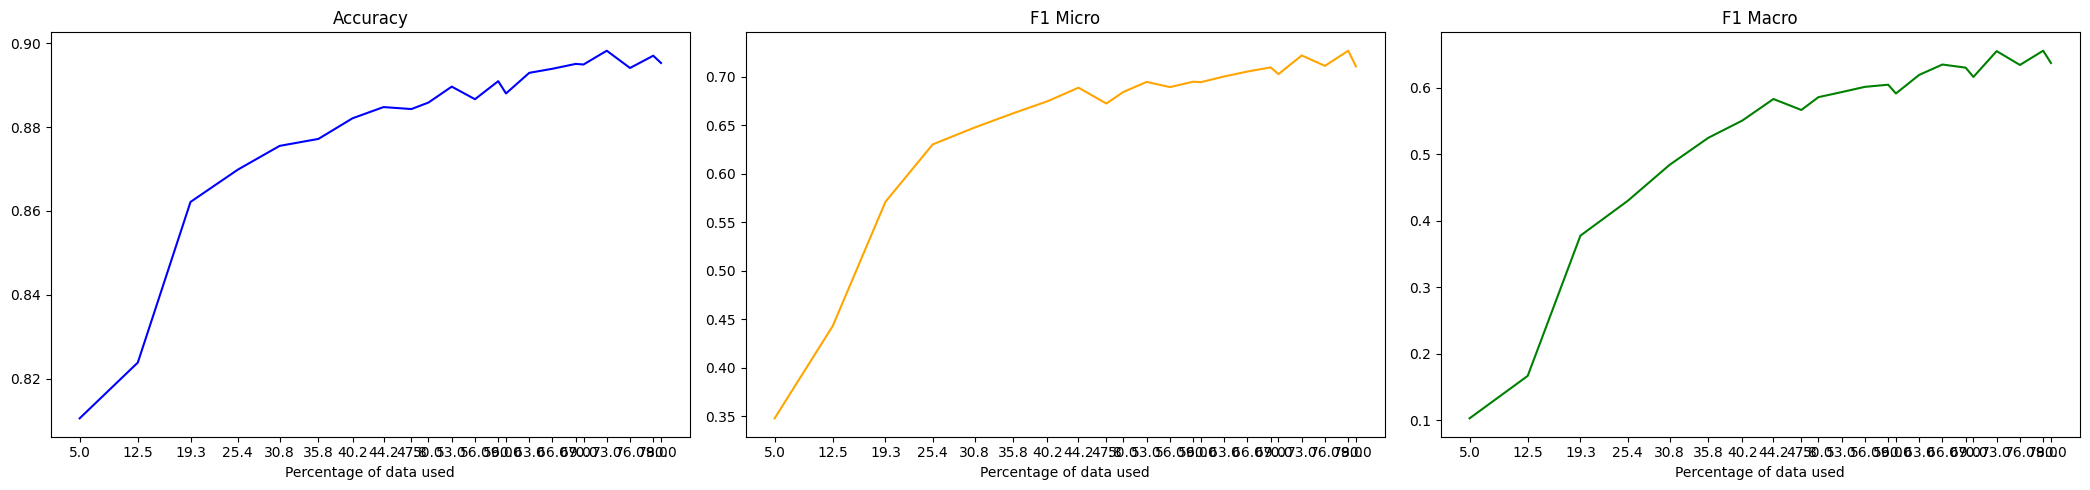

In [23]:
active_learning([50, 67, 42], 0)